# Intro to JuMP

This notebook is based on materials by Kayla Cummings
(https://github.com/kscummings/15.S60_2022/tree/main/6_linear_programming).


### Notebook outline

1. Build and solve a simple model (easy)
2. Incorporate some fancier data pre-processing
3. Build and solve a large number of similar LPs (modularize!)

_Note_: The preassignment did not include packages Distances, Random, and StatsBase; please install those by uncommenting the line below.

[JuMP.jl](https://github.com/JuliaOpt/JuMP.jl) is a high-level modeling language for mathematical optimization developed in Julia. It currently supports 
- a bajillion solvers (Artelys Knitro, BARON, Bonmin, Cbc, Clp, Couenne, CPLEX, ECOS, FICO Xpress, GLPK, Gurobi, Ipopt, MOSEK, NLopt, SCS ...) 
- many problem classes, including linear programming, (mixed) integer programming, second-order conic programming, semidefinite programming, and nonlinear programming.

![figures/supported-solvers.png](figures/supported-solvers.png)

In [1]:
# using Pkg; Pkg.add("Distances"); Pkg.add("StatsBase"); Pkg.add("Random")

In [35]:
using JuMP, Gurobi, CSV, DataFrames, Plots, Distances, StatsBase, Random

const GRB_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-16


## 1. Building and solving simple models

Let's recall the basic syntax of building a linear program in Julia with JuMP.

In [3]:
#--- generate some random parameters 
n = 6
A = round.(rand(n, n), digits=2)   # random resource matrix
b = round.(rand(n) * 5, digits=2); # randm demand

How would be formulate the following?

\begin{align}
\min \quad &e^\top x \\
\text{s.t. } \quad &A x\geq b \\
&x \geq 0
\end{align}

In [4]:
#--- construct the model
m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource, A*x .>= b)
JuMP.@objective(m, Min, sum(x));

UndefVarError: UndefVarError: `GRB_ENV` not defined

In [5]:
#--- look at it!
JuMP.latex_formulation(m)

UndefVarError: UndefVarError: `m` not defined

In [6]:
#--- solve!
JuMP.optimize!(m)

UndefVarError: UndefVarError: `m` not defined

In [7]:
#--- optimal value?
obj = JuMP.objective_value(m)

UndefVarError: UndefVarError: `m` not defined

### That's quite the print-out! What do we do with it? 
The solver log has some useful information! ([Here](https://www.gurobi.com/documentation/11.0/refman/logging.html) is a comprehensive summary of Gurobi logging.)

* Summary of model size
* Parameter ranges (troubleshoot numerical errors)
* Dual simplex solution progress
    * Objective value of current basis
    * Magnitudes of primal and dual infeasibility
    * Iteration and time elapsed
* Objective value
* Tottal solve time
* Callback summaries

However, if you want to turn it off...

In [8]:
solver = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0)
m = JuMP.Model(solver)

# while we're at it... an equivalent way to formulate, without matrix ops
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource[i=1:n], sum(A[i,j] * x[j] for j in 1:n) >= b[i])
JuMP.@objective(m, Min, sum(x[j] for j in 1:n));

UndefVarError: UndefVarError: `GRB_ENV` not defined

In [9]:
#--- so quiet...
JuMP.optimize!(m)

UndefVarError: UndefVarError: `m` not defined

In [10]:
#--- equivalent?
JuMP.objective_value(m) == obj

UndefVarError: UndefVarError: `m` not defined

### Gurobi parameters

Gurobi offers a lot of solver parameters. 
Here are just a few:

* ``TimeLimit``: Max time solver will run (in seconds)
* ``NodeLimit``: Max nodes to explore before solver quits
* ``MIPGap``: Termination criterion for relative gap $\frac{UB-LB}{LB}$.
* ``MIPFocus``: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution).

Set their values in the solver definition.
```
solver = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0, "TimeLimit" => 60)
```


Some parameters for simplex method and interior point method (barrier method)


The full list of all parameters https://www.gurobi.com/documentation/11.0/refman/parameters.html

![figures/example_parameters.png](figures/example_parameters.png)



### Common model queries

What other information do we want to squeeze out of our model?
* Primal and dual solutions
* Termination status (possible outcomes [here](https://jump.dev/JuMP.jl/stable/moi/reference/models/#MathOptInterface.TerminationStatusCode))

In [11]:
@show JuMP.value.(x);                # primal solution

UndefVarError: UndefVarError: `x` not defined

In [12]:
@show JuMP.dual.(resource);  # dual solution accociated with the constraint "resource"

UndefVarError: UndefVarError: `resource` not defined

In [13]:
@show JuMP.termination_status(m);     # did the model get solved to optimality?

UndefVarError: UndefVarError: `m` not defined

### Exercise

Implement and solve the dual of our tiny optimization model up there. Verify that you get the same objective value!

In [14]:
dual_problem = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))

# Define variables, constraints, the objective function and solve the problem
####
#### YOUR CODE HERE
####

UndefVarError: UndefVarError: `GRB_ENV` not defined

In [15]:
# Check if you're correct
abs(JuMP.objective_value(dual_problem) - obj) < 1e-5

UndefVarError: UndefVarError: `dual_problem` not defined

### Where to get help

- JuMP docs https://jump.dev/JuMP.jl/stable/
- JuMP issues https://github.com/JuliaOpt/JuMP.jl/issues
- Discourse https://discourse.julialang.org/c/domain/opt
- JuMP style guide https://jump.dev/JuMP.jl/stable/developers/style/
- JuMP supported solvers https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers
- Some (old but useful) tutorials on JuMP https://github.com/jump-dev/JuMPTutorials.jl

## 2. Building a model with fancy data pre-processing

That was great and all, but what about the unsexy side of things where I have a bunch of datasets that I need to translate into model inputs? How do I do that and stay organized?? Let's set up a case study.

Greater Boston Area needs to make sure that its citizens are vaccinated from a latest varant of COVID. Their goal is to vaccinate everyone. Let's respect a statewide budget and minimize total distance traveled by those being vaccinated. Where should GBA set up temporary mass vaccination sites?

**Sets**
* Cities and towns $C$
* Potential vaccination facilities $F$

**Parameters**
* $r_{j}$ - number of persons in city $j \in C$ who need to be vaccinated 
* $d_{ij}$ - distance from facility $i \in F$ to city $j \in C$ (assume the same for everyone in area $j$)
* $K_i$ - fixed cost of opening facility $i \in F$ 
* $P_i$ - number of persons who can be vaccinated at facility $i \in F$, assuming the facility is open
* $B$ - budget for opening facilities
* $L$ - maximum number of vaccination sites open

**Decisions**
* $x_{ij}$ - number of people in city $j \in C$ vaccinated at site $i \in F$ 
* $y_i$ - whether facility $i \in F$ is open

**Formulation**

\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} d_{ij} \cdot x_{ij} \\
\text{s.t. } \quad &\sum_{i \in F} K_i \cdot y_i \leq B && &&\text{Budget} \\
&\sum_{i \in F} y_i \leq L && &&\text{Location limit}\\
&\sum_{j \in C}x_{ij} \leq P_i \cdot y_{i} &&i \in F &&\text{Capacity} \\
&\sum_{i \in F}x_{ij} = r_{j} &&j \in C &&\text{Demand} \\
&x_{ij} \geq 0 &&i \in F, j \in C \\
&y_{i} \in \{0,1\} &&i \in F \\
\end{align}

### 2.0 From raw data to formatted data

* MA population at ZIP code level ([source](https://censusreporter.org/data/table/?table=B01003))
* Prettier ZIP code names ([source](https://www.zip-codes.com/state/ma.asp))
* Potential facility locations and their capacities/costs (source: simulated in Python. The script is in the raw data directory)

### 2.1 From formatted data to model inputs

Let's read in our formatted data toward constructing the sets and parameters that we need.

In [16]:
#--- data paths
data_dir = joinpath("data", "formatted")
population_data_path = joinpath(data_dir, "ma_population.csv")
facility_data_path = joinpath(data_dir, "facilities.csv");

In [17]:
#--- population data
population_data = CSV.read(population_data_path,DataFrame)

Row,geoid,population,pop_error,longitude,latitude,city,county,zip_code
,String15,Float64,Float64,Float64,Float64,String31,String15,String7
1,86000US01730,14070.0,52.0,-71.2783,42.4969,Bedford,Middlesex,z01730
2,86000US01731,2059.0,142.0,-71.2795,42.4568,Hanscom AFB,Middlesex,z01731
3,86000US01801,40359.0,91.0,-71.1542,42.4869,Woburn,Middlesex,z01801
4,86000US01803,27650.0,67.0,-71.2026,42.5022,Burlington,Middlesex,z01803
5,86000US01810,35816.0,55.0,-71.1651,42.6465,Andover,Essex,z01810
6,86000US01821,32797.0,525.0,-71.2522,42.5502,Billerica,Middlesex,z01821
7,86000US01833,8695.0,20.0,-70.9821,42.724,Georgetown,Essex,z01833
8,86000US01840,5573.0,567.0,-71.1602,42.7069,Lawrence,Essex,z01840
9,86000US01841,49367.0,1134.0,-71.1651,42.7108,Lawrence,Essex,z01841


In [18]:
#--- facility data (simulated)
facility_data = CSV.read(facility_data_path,DataFrame)

Row,latitude,longitude,capacity,fixed_cost,facility_id
,Float64,Float64,Float64,Float64,String7
1,42.467,-71.1851,403680.0,4.0458e5,fac3
2,42.5802,-70.7361,53920.0,54819.7,fac36
3,42.4578,-71.0891,227470.0,2.2837e5,fac20
4,42.5532,-71.1816,233860.0,2.3476e5,fac19
5,42.587,-71.2954,106320.0,1.0722e5,fac14
6,42.4348,-70.8908,35110.0,36009.7,fac27
7,42.683,-70.8731,63810.0,64709.7,fac41
8,42.2029,-70.8373,84930.0,85829.7,fac47
9,42.5806,-70.9341,274150.0,2.7505e5,fac30


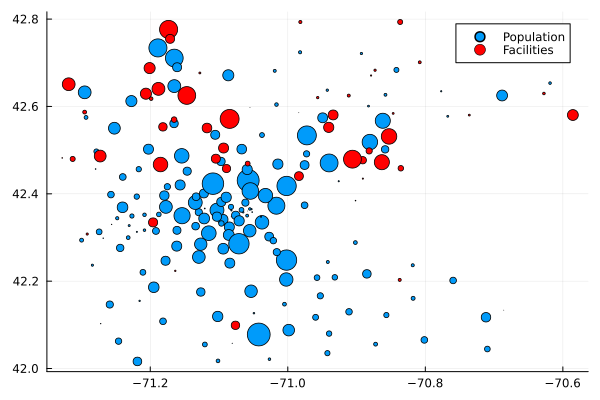

In [19]:
#--- visualize
scatter(population_data[:, "longitude"], population_data[:, "latitude"], markersize=0.0002*population_data[:, "population"], label="Population")
scatter!(facility_data[:, "longitude"], facility_data[:, "latitude"], color="red", markersize=0.00002*facility_data[:, "capacity"],label="Facilities")

Imagine a map of the GBA underneath the dots... ;)

### What input formatting needs to be done?

Some model attributes are straightforward translations of dataframe columns:
* zip codes and facility IDs - $C, F$
* facility capacities - $P$
* fixed facility costs - $K$
* demand - $r$

Others are constants:
* budget - $B$
* max number of facilities - $L$

And some need to be computed:
* distances between facilities and residents - $d$

### Collecting all of the model components

This is a lot of stuff to keep track of. How can I keep everything organized?

We will create a Julia struct, which is a flexible data structure that can keep track of attributes of all types. If you are familiar with Python, a struct is analogous to a class, but we cannot assign methods to it.

In [20]:
struct FacilityLocationData
    #--- constants 
    L::Int64        # location limit
    B::Float64      # budget
    
    #--- sets
    C::Vector{String}  # zip codes 
    F::Vector{String}  # facility IDs
    
    #--- parameters
    r::Dict{String,Int64}                  # demand 
    P::Dict{String,Int64}                  # facility capacity
    K::Dict{String,Float64}                # fixed cost
    d::Dict{Tuple{String,String},Float64}  # distances
    
    #--- extra information
    city_county::Dict{String,String}             # city/county zip code map
    population_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each zip code
    facility_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each facility
end

We cannot change the struct once it has been created. If we want to be able to change values, we create a mutable struct instead. (Just put the word "mutable" in front of struct at the top of the previous cell.)

Let's build a constructor for our FacilityLocationData data structure. We are taking advantage of the fact that Julia functions can have many _methods_.

### Exercise

Part of the constructor has been completed before you. But part of it hasn't... fill in the missing model components.

In [21]:
"""
CONSTRUCTOR

### Keywords
* `pop_fp` - MA population filepath
* `fac_fp` - facility location filepath
* `L` - max facility locations that can be opened
* `B` - budget
"""
function FacilityLocationData(
        pop_fp::String,
        fac_fp::String,
        L::Int64=20,
        B::Float64=4e6
    )
    # read in raw data
    # note: this code is redundant with the above code, but that was preliminary data exploration!
    population_data = CSV.read(pop_fp, DataFrame)
    population_data[:, "zip_code"] = replace.(population_data[:, "zip_code"], "z" => "")
    facility_data = CSV.read(fac_fp, DataFrame)
    
    # sets
    C = String.(population_data[:, "zip_code"])
    F = String.(facility_data[:, "facility_id"])
    
    # some extra info available in the pop dataframe
    city_county = Dict{String,String}(
        row["zip_code"] => row["city"] .* ", " .* row["county"] for row in eachrow(population_data) 
            if (!ismissing(row["city"]) & !ismissing(row["county"]))
    )
    population_gps = Dict{String,Tuple{Float64,Float64}}(
        population_data[:, "zip_code"] .=> tuple.(population_data[:, "latitude"], population_data[:, "longitude"])
    )
    facility_gps = Dict{String,Tuple{Float64,Float64}}(
        facility_data[:, "facility_id"] .=> tuple.(facility_data[:, "latitude"], facility_data[:, "longitude"])
    )

    # facility capacity and fixed cost parameters
    P = Dict{String,Int64}(F .=> facility_data[:, "capacity"]) 
    K = Dict{String,Float64}(F .=> facility_data[:, "fixed_cost"])
                    
    # demand parameters
    r = Dict{String,Int64}(population_data[:, "zip_code"] .=> population_data[:, "population"])
                
    # distances
    hav = Distances.Haversine(3958.8); # the radius of Earth in miles
    d = Dict{Tuple{String,String},Float64}(
        (res, fac) => Distances.evaluate(hav, rgps, fgps) for (res, rgps) in population_gps for (fac, fgps) in facility_gps
    )
                            
    return FacilityLocationData(L, B, C, F, r, P, K, d, city_county, population_gps, facility_gps)
end

FacilityLocationData

In [22]:
FLD = FacilityLocationData(population_data_path, facility_data_path);

Now we can access any model attribute by name. Try it out!

In [23]:
# budget
@show FLD.B;

FLD.B = 4.0e6


In [24]:
# zip codes
@show FLD.C;

FLD.C = ["01730", "01731", "01801", "01803", "01810", "01821", "01833", "01840", "01841", "01843", "01844", "01845", "01852", "01862", "01864", "01867", "01876", "01880", "01887", "01890", "01901", "01902", "01904", "01905", "01906", "01907", "01908", "01915", "01921", "01923", "01929", "01930", "01937", "01938", "01940", "01944", "01945", "01949", "01960", "01966", "01969", "01970", "01982", "01983", "01984", "02021", "02025", "02026", "02030", "02032", "02035", "02043", "02045", "02047", "02048", "02050", "02061", "02062", "02066", "02067", "02071", "02072", "02081", "02090", "02108", "02109", "02110", "02111", "02113", "02114", "02115", "02116", "02118", "02119", "02120", "02121", "02122", "02124", "02125", "02126", "02127", "02128", "02129", "02130", "02131", "02132", "02134", "02135", "02136", "02138", "02139", "02140", "02141", "02142", "02143", "02144", "02145", "02148", "02149", "02150", "02151", "02152", "02155", "02163", "02169", "02170", "02171", "02176", "02180", "02184", "

In [25]:
# facility capacity
@show FLD.P;

FLD.P = Dict("fac27" => 35110, "fac24" => 245890, "fac32" => 301710, "fac23" => 173030, "fac26" => 152870, "fac37" => 205090, "fac31" => 37540, "fac42" => 430420, "fac33" => 1890, "fac13" => 355410, "fac22" => 496500, "fac29" => 82910, "fac2" => 20680, "fac35" => 134830, "fac25" => 282310, "fac30" => 274150, "fac8" => 55820, "fac7" => 87040, "fac14" => 106320, "fac43" => 80400, "fac38" => 98810, "fac39" => 526370, "fac34" => 139720, "fac20" => 227470, "fac49" => 60530, "fac19" => 233860, "fac36" => 53920, "fac9" => 493760, "fac6" => 328060, "fac45" => 52490, "fac16" => 250860, "fac47" => 84930, "fac28" => 418940, "fac50" => 42030, "fac18" => 267290, "fac3" => 403680, "fac41" => 63810, "fac4" => 276590, "fac5" => 358250, "fac17" => 308870, "fac15" => 155900, "fac1" => 140790, "fac21" => 21440, "fac48" => 252740, "fac46" => 233780, "fac40" => 72400, "fac10" => 250110, "fac12" => 308510, "fac44" => 65770, "fac11" => 502910)


What was the point of all of that? Can't we just use the parameter names themselves?

Well, good extensible code is _modularized_! By limiting all of our model components to one data structure, we have drastically simplified the arguments to any functions that build and solve models.

We want code that looks roughly like this:

```
FLD = FacilityLocationData(data_dir)
model = build_model(FLD)
solution = solve_model(model)
```

Look how lovely and legible that is! As we know, line 1 hides a lot of work. But now we have designed narrative, extensible code. If we need more info, we can go to the function(s) containing that info. Let's get to work on lines 2 and 3...

### 2.2 Model formulation

Now what? Let's work on a `build_model` function.



### Exercise

Formulate the above model in JuMP using the inputs we just formatted.

Before you begin, here is some syntax that may be useful.

```
@variables m begin
    variable1_name >= 0
    variable2_name, Bin
end

@constraints m begin
    opt_constraint1_name, constraint1
    opt_constraint2_name[constraint2_index], constraint2
end
```

The above is a less verbose, equivalent way of coding:
```
@variable(m, variable1_name >= 0)
@variable(m, variable2_name, Bin)
@constraint(m, opt_constraint1_name, constraint1)
@constraint(m, opt_constraint2_name[constraint2_index], constraint2)
```

As a reminder, here's the formulation.


\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} d_{ij} \cdot x_{ij} \\
\text{s.t. } \quad &\sum_{i \in F} K_i \cdot y_i \leq B && &&\text{Budget} \\
&\sum_{i \in F} y_i \leq L && &&\text{Location limit}\\
&\sum_{j \in C}x_{ij} \leq P_i \cdot y_{i} &&i \in F &&\text{Capacity} \\
&\sum_{i \in F}x_{ij} = r_{j} &&j \in C &&\text{Demand} \\
&x_{ij} \geq 0 &&i \in F, j \in C \\
&y_{i} \in \{0,1\} &&i \in F \\
\end{align}

In [26]:
"""
Build MA facility location model.

### Keywords 
* `FLD` - FacilityLocationData
### Returns
* JuMP.Model representation of MA's mass vaccination site problem
"""
function build_model(FLD::FacilityLocationData)
    m = JuMP.Model(Gurobi.Optimizer)
    
    @variables m begin 
        x[FLD.F, FLD.C] >= 0
        y[FLD.F], Bin
    end
    # this is the same with:
    # YOUR CODE HERE
    # define variables in our old way
    
    @expression(m, budget, sum(FLD.K[i] * y[i] for i in FLD.F))
    
    @constraints m begin 
        budget <= FLD.B
        num_loc, sum(y) <= FLD.L
        capacity[i in FLD.F], sum(x[i,:]) <= FLD.P[i] * y[i]
        demand[j in FLD.C], sum(x[:,j]) == FLD.r[j]
    end
    # this is the same with:
    # YOUR CODE HERE
    # define constraints in our old way
    
    
    @objective(m, Min, sum(FLD.d[(j,i)] * x[i,j] for i in FLD.F for j in FLD.C))
                                        
    return m
end

build_model

In [27]:
#--- try it out!
m = build_model(FLD)

Set parameter Username


ErrorException: Gurobi Error 10009: Version number is 12.0, license is for version 11.0

### 2.3 Solve model

Let's build a function to solve our model. Then we can explore and interpret our optimal solution.

In [28]:
"""
Solve a mass COVID vaccination facility location model 

### Keywords 
* `model` - the model
### Returns 
* termination status
* objective value
* optimal solution (x, y)
"""
function solve_model(model::JuMP.Model)
    JuMP.optimize!(model)
    term_status = JuMP.termination_status(model)
    if term_status == MOI.OPTIMAL
        obj = JuMP.objective_value(model)
        x_val = JuMP.value.(model[:x])
        y_val = JuMP.value.(model[:y])
        #JuMP.value(model[:budget])
        return term_status, obj, (x_val, y_val)
    end
    return term_status, nothing, nothing
end
# this function is looking the other way while we talk about type stability...

solve_model

In [29]:
ts, obj, (x_val, y_val) = solve_model(m);

UndefVarError: UndefVarError: `m` not defined

### 2.4 Put it all together

Let's see our three-line script in action :-)

In [30]:
F = FacilityLocationData(population_data_path, facility_data_path)
m = build_model(F)
ts, obj, sol = solve_model(m);

Set parameter Username


ErrorException: Gurobi Error 10009: Version number is 12.0, license is for version 11.0

## 3. Analyze outputs

There are a few scenarios where our 3-line script is going to save us a lot of trouble:
* Different (but very similar) datasets - e.g., repeat for all 50 states, not just MA
* Sensitivity analysis

### Exercise
Let's do a little bit of the latter. We will plot the effect of budget on total distance traveled by all residents to get their vaccines. Fix the number of facilities at 20.

In [31]:
budget = [3 + i * .2 for i in 0:10] .* 10^6
NB = length(budget)
dist = Float64[NaN for _ in 1:NB]

for i in 1:NB
    F = FacilityLocationData(population_data_path, facility_data_path, 20, budget[i])
    
    ##### YOUR CODE HERE
    
end


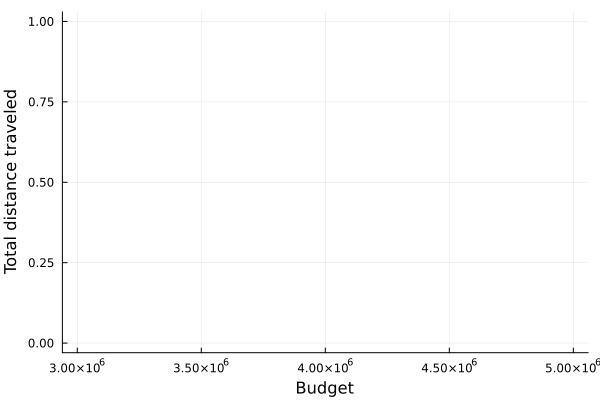

In [32]:
scatter(budget, dist, ylab="Total distance traveled", xlab="Budget", legend=false)

Check: is the distance decreasing as budget increases?

# Appendix

Here's how the facility data was simulated.

In [33]:
# using Pkg; Pkg.add("Distributions")
using Distributions, Random
Random.seed!(47)
pop_vec = population_data[:, "population"]
num_facilities = 50

# distributions
dist_lat = Normal.(population_data[:,"latitude"], 0.05)
dist_lon = Normal.(population_data[:, "longitude"], 0.05)
dist_cap = Normal(100, 10)
dist_fc = Normal(1e3, 100)

# locations (who knows if these are even in MA? on land??? oh well!)
fac_lat = rand.(dist_lat)
fac_lon = rand.(dist_lon)

# parameters
P = max.(round.(pop_vec .* 10 .+ rand(dist_cap)), 0)
K = pop_vec .* 10 .+ rand(dist_fc)

# facility IDs
facility_id = "fac" .* string.([i for i in 1:length(fac_lat)])

# format into a CSV
facilities = DataFrame(latitude = fac_lat, longitude = fac_lon, capacity = P, fixed_cost = K, facility_id = facility_id)
fac_idx = StatsBase.sample(1:nrow(facility_data), num_facilities, replace=false)
facilities = facilities[fac_idx, :]  
CSV.write(joinpath("data", "formatted", "facilities.csv"), facilities);